# 2. Fixed parameter accuracy vs. Overall best accuracy

We compare the fixed best value with overall best values and see whether the fixed accuracy scores are significantly different from the overall accuracy scores.

In [1]:
import pandas as pd
from hyperimp import evaluate_experiments as evalexp

In [9]:
# load test set scores (accuracy) of verification experiment
rs__svm_rbf_fix = pd.read_csv('data/verification_svm_rbf.csv')
rs__svm_sigmoid_fix = pd.read_csv('data/verification_svm_sigmoid.csv')
rs__rf_fix = pd.read_csv('data/verification_rf.csv')

rs__svm_rbf_nonfix = pd.read_csv('data/rs_svm_rbf.csv')
rs__svm_sigmoid_nonfix = pd.read_csv('data/rs_svm_sigmoid.csv')
rs__rf_nonfix = pd.read_csv('data/rs_rf.csv')

In [3]:
# List OpenMLCC18 datasets
import openml
openMLCC18 = openml.study.get_study(99,'tasks').tasks

## 2.1 Algorithm: SVM RBF; Parameter: C(omplexity)

Does tuning the C parameter of a Support Vector Machine with an RBF kernel result in better performance, or can we just leave it at some default value?

We compare two different experiments. In one experiment, we optimize over the entire search space. In the second experiment, we fix one of the hyperparameters to a specific value and optimize over all other parameters. This is done using a 10 x 3 fold nested cross validation. That is, the hyperparameters are optimized in a 3-fold inner cross validation. For each of the 10 outer folds, the best model found in the inner CV is tested on the test set.

In [5]:
df_fix = rs__svm_rbf_fix[rs__svm_rbf_fix['dataset'].isin(openMLCC18)]
df_nonfix = rs__svm_rbf_nonfix[rs__svm_rbf_nonfix['dataset'].isin(openMLCC18)]
parameter = 'C'
lb = 3187
ub = 10097
seed = 10

# find fixed parameter and top 10 data
data = evalexp.generate_data_new(df_fix, df_nonfix, parameter, lb, ub, seed)

In [6]:
# ANOVA
model, aov_table = evalexp.aov(data)
print(aov_table)
print('\n')
print('ANOVA coefficient %s : %.5f \n' % (model.params.index[1], model.params[1]))

# Wilcoxon
T, p = evalexp.wilcox(data)
if p < 0.05:
    print('Wilcoxon H0 rejected with T = %.2f and p-value : %.2e' % (T, p))
else:
    print('Wilcoxon H0 not rejected with T = %.2f and p-value : %.2e' % (T, p))

                       sum_sq     df           F    PR(>F)  omega_sq
C(type)              0.002287    1.0    3.459767  0.063205  0.000062
C(dataset)          25.493160   49.0  786.946130  0.000000  0.974932
C(type):C(dataset)   0.024302   49.0    0.750188  0.896889 -0.000310
Residual             0.595011  900.0         NaN       NaN       NaN


ANOVA coefficient C(type)[T.not fixed] : 0.00063 

Wilcoxon H0 not rejected with T = 348.50 and p-value : 5.64e-02


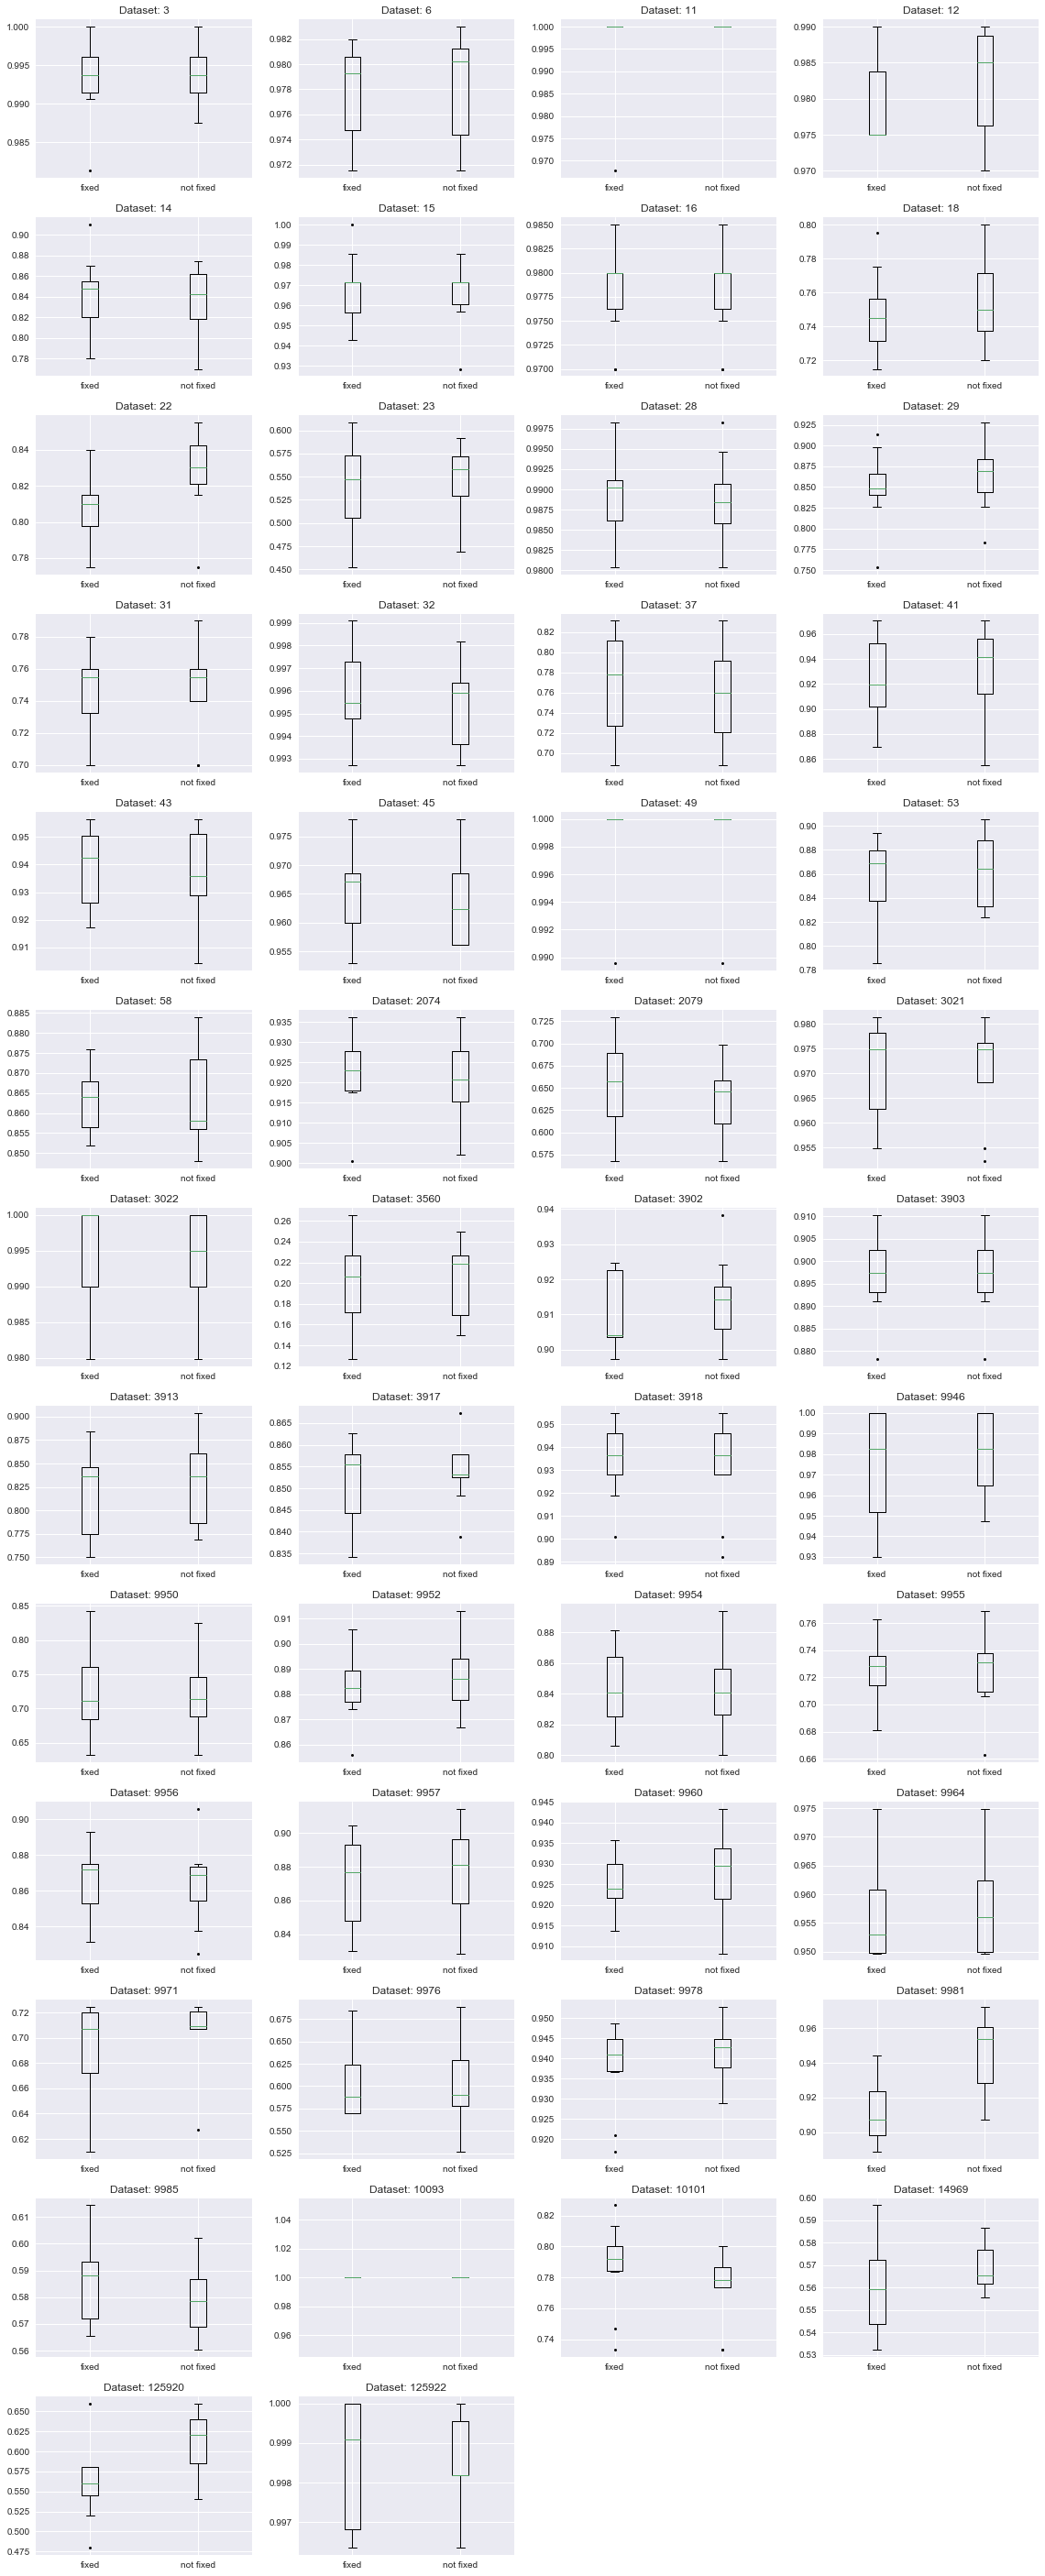

In [7]:
# generate boxplots
cols = 4
evalexp.boxplot(cols, data)

## 2.2 Algorithm: Random Forest; Parameter: min_samples_leaf

In [39]:
df_fix = rs__rf_fix[rs__rf_fix['dataset'].isin(openMLCC18)]
df_nonfix = rs__rf_nonfix[rs__rf_nonfix['dataset'].isin(openMLCC18)]

parameter = 'min_samples_leaf'
lb = 1
ub = 1
seed = 10

# find fixed parameter and top 10 data
data = evalexp.generate_data_new(df_fix, df_nonfix, parameter, lb, ub, seed)

In [40]:
# ANOVA
model, aov_table = evalexp.aov(data)
print(aov_table)
print('\n')
print('ANOVA coefficient %s : %.5f \n' % (model.params.index[1], model.params[1]))

# Wilcoxon
T, p = evalexp.wilcox(data)
if p < 0.05:
    print('Wilcoxon H0 rejected with T = %.2f and p-value : %.2e' % (T, p))
else:
    print('Wilcoxon H0 not rejected with T = %.2f and p-value : %.2e' % (T, p))

                       sum_sq      df           F    PR(>F)  omega_sq
C(type)              0.009220     1.0   13.293860  0.000279  0.000337
C(dataset)          24.491849    59.0  598.515833  0.000000  0.966983
C(type):C(dataset)   0.034966    59.0    0.854475  0.774892 -0.000236
Residual             0.749062  1080.0         NaN       NaN       NaN


ANOVA coefficient C(type)[T.not fixed] : -0.00094 

Wilcoxon H0 rejected with T = 416.00 and p-value : 2.39e-04


fixed
0.848834967133641
not fixed
0.8432911120416835


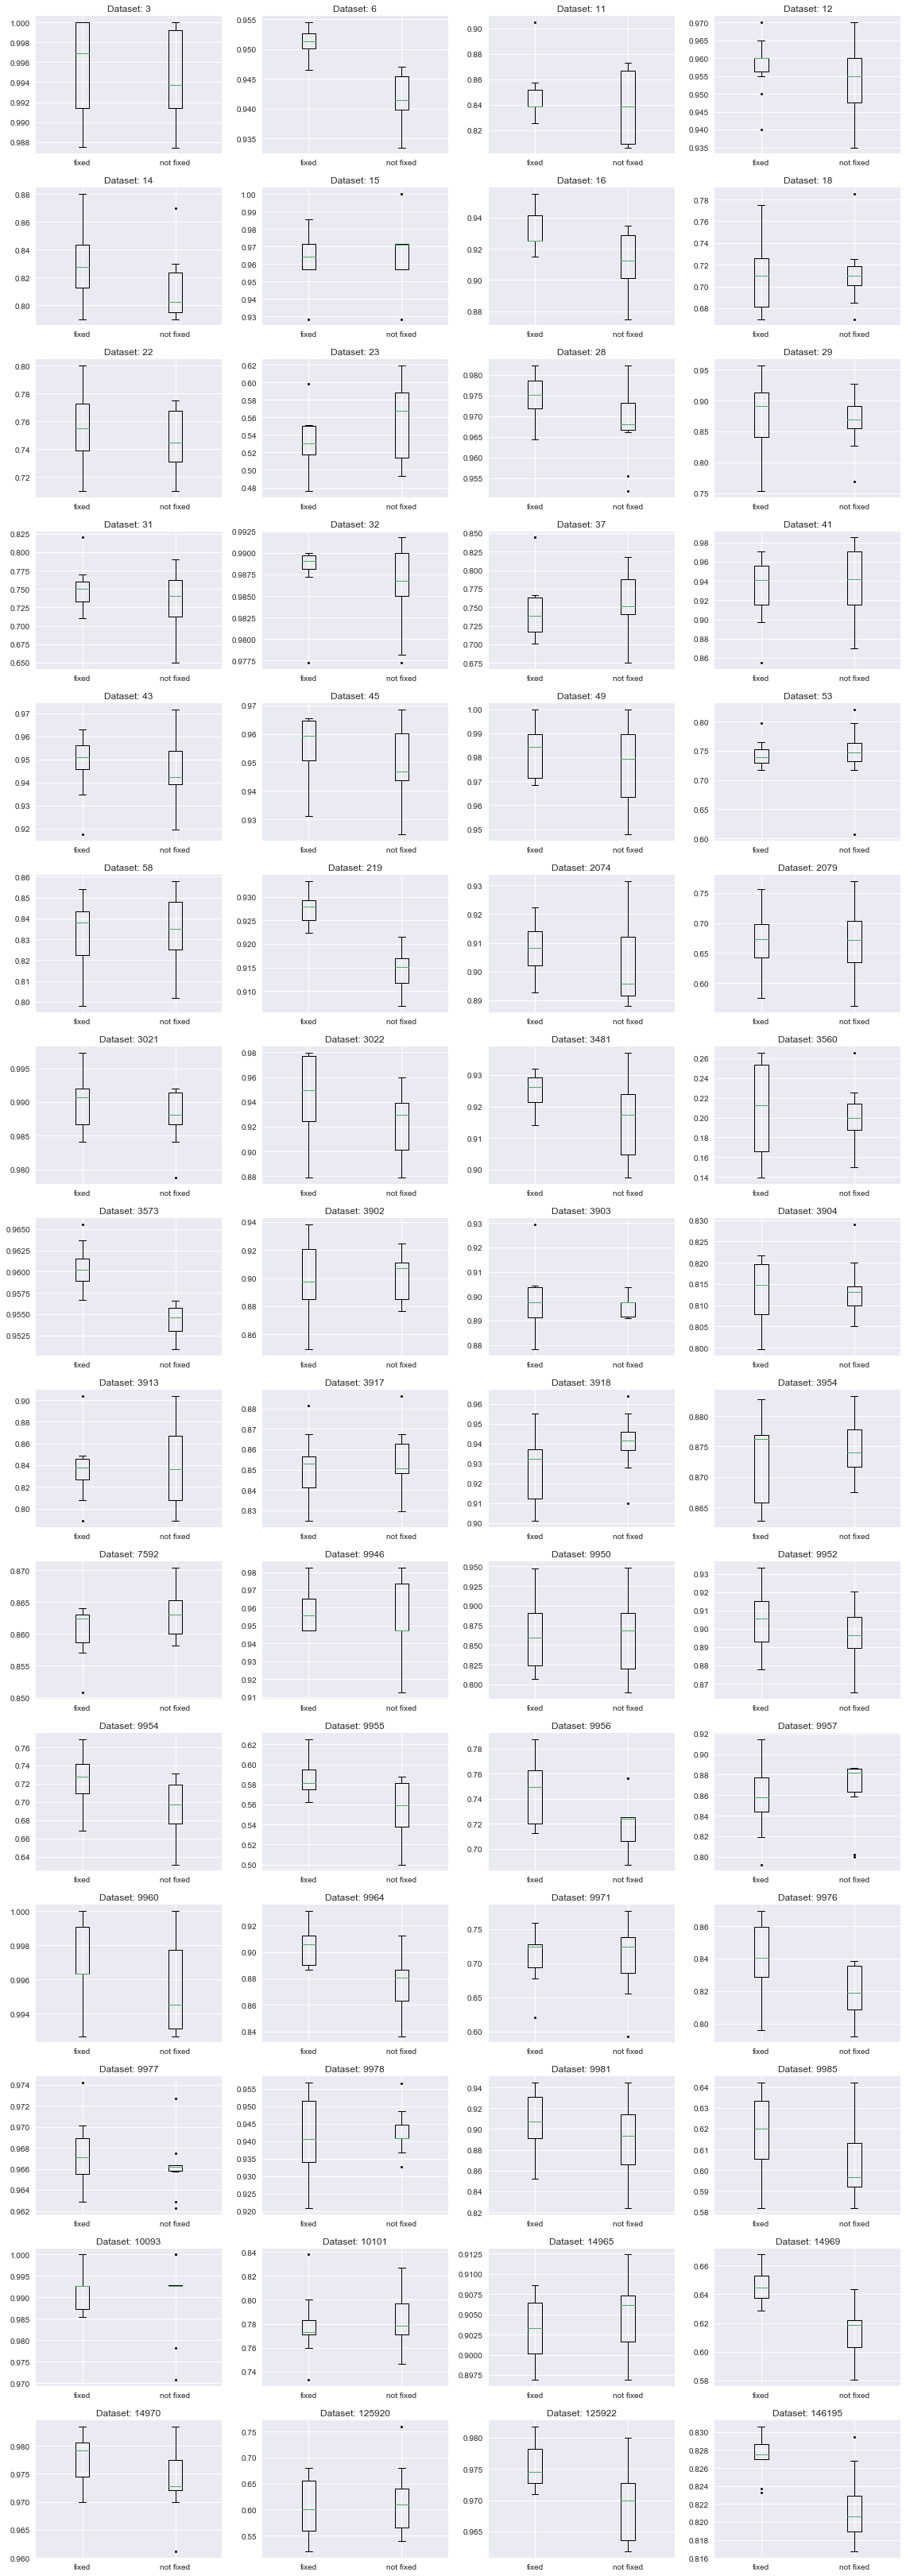

In [36]:
for fix_type, fix_data in data.groupby('type'):
    print(fix_type)
    print(fix_data.groupby('dataset').mean()['accuracy'].mean())

# generate boxplots
cols = 4
evalexp.boxplot(cols, data)

## 2.3 Algorithm: SVM sigmoid; Parameter: tolerance

**!! No full random search data available for all datasets, so uses old method !!**

In [ ]:
df = rs__svm_sigmoid
parameter = 'tol'
lb = 0.00150
ub = 0.00346

# find fixed parameter and top 10 data
data = evalexp.generate_data(df, parameter, lb, ub)

In [ ]:
# Generate box plots
cols = 4
evalexp.boxplot(cols, data)

In [ ]:
# ANOVA
model, aov_table = evalexp.aov(data)
print(aov_table)
print('\n')
print('ANOVA coefficient %s : %.5f \n' % (model.params.index[1], model.params[1]))

# Wilcoxon
T, p = evalexp.wilcox(data)
if p < 0.05:
    print('Wilcoxon H0 rejected with T = %.2f and p-value : %.2e' % (T, p))
else:
    print('Wilcoxon H0 not rejected with T = %.2f and p-value : %.2e' % (T, p))

In [ ]:
errors_fixed = 1 - pd.DataFrame(data[data['type'] == 'fixed'].groupby(['dataset']).mean())['accuracy']
errors_overall = 1 - pd.DataFrame(data[data['type'] == 'overall'].groupby(['dataset']).mean())['accuracy']
relative_risk = errors_fixed.divide(errors_overall)
relative_risk.replace([np.inf, -np.inf], np.nan).dropna().hist()
plt.show()

import statsmodels.stats.api as sms
sms.DescrStatsW(relative_risk.replace([np.inf, -np.inf], np.nan).dropna()).tconfint_mean(0.1)